# Ex. 3 - Decision Trees and Decision Forests

In the last exercise we discussed how to define a liinear classification algorithm and how to measure its performace. For simplicity we focussed on the problems with two variables, but we have seen that adding more variable is not always an optimal choice. 

We move now to discuss more advanced classification methods, and in particular *decision trees* and *neural networks*. 

In this notebook we will discuss **Decision Trees**.

Decision Trees (DTs) are a non-parametric supervised learning method used for
classification and regression. The goal is to create a model that predicts the
value of a target variable by learning simple decision rules inferred from the
data features.
For instance, in the example below, decision trees learn from data to
approximate a sine curve with a set of if-then-else decision rules.
The deeper the tree, the more complex the decision rules and the fitter the model.

Some advantages of decision trees are:
 - Simple to understand and to interpret. Trees can be **visualised**.
 - Requires **little data preparation**. Other techniques often require data normalization, 
   Decision Trees are blind to the **normalization of variables** since they rely on hard
   cut requirements (variable larger than a threshold). 
 - The **cost of using the tree** (i.e., predicting data) is logarithmic in the number 
   of data points used to train the tree.
 - Uses a **white box** model. If a given situation is observable in a model, the 
   explanation for the condition is easily explained by boolean logic. 
   By contrast, in a black box model (e.g., in an artificial neural network), 
   results may be more difficult to interpret.
 - It is a very robust algorithm: it performs well even if its 
   assumptions are somewhat violated by the true
   model from which the data were generated.

The disadvantages of decision trees include:
 - Decision-tree learners can create over-complex trees that 
   do not generalise the data well. This is called **overfitting**. 
   Mechanisms such as pruning (not currently supported), setting the minimum number 
   of samples required at a leaf node or setting the maximum depth of 
   the tree are necessary to avoid this problem.
 - Decision trees can be **unstable** because small variations in the data might result 
   in a completely different tree being generated. This problem is mitigated by using 
   decision trees within an ensemble.
 - There are concepts that are hard to learn because decision trees do not 
   express them easily, such as XOR, parity or multiplexer problems.



Let's start by preparing the environment defining the library and the datasets.
Note that this time we define two datasets for signal and background: one will be used for the *traning* of the algorithm and one used for measuring the performance of the algorithm on a statistically independent sample, the *test* sample. 

In [ ]:
!pip install uproot iminuit
files = {
    "WWTo2L2Nu1.root": "1oix_LaKYaPgMPdOcG8O6_qwq3a0CD1EO",
    "GGToHToWWTo2L2Nu1.root": "1lD3JG12bP21oN94bEmDOZuLQBd4y2Dwk",
    "WWTo2L2Nu2.root":"1KTlRb66tSPajEpJJoLqmqisBQW-Pakjk",
    "GGToHToWWTo2L2Nu2.root": "1X72-i7qrYqQyA02jCESFFlSq33__x_tq"}
!rm -f *.root
import os 
for kv in files.items():
  if not os.path.exists(kv[0]):
    a = os.system ( "wget -O %s --no-check-certificate 'https://docs.google.com/uc?export=download&id=%s'" % kv )
    if a:
      print (a)
      print ('https://docs.google.com/uc?export=download&id=%s' % kv[1])
      raise IOError ( "Could not download %s (%s)" % kv ) 

import uproot, pandas as pd
signal      = uproot.open ( "GGToHToWWTo2L2Nu2.root" )['latino'].arrays(library='pd')
background  = uproot.open ( "WWTo2L2Nu2.root" )['latino'].arrays(library='pd')
signal['label'] = 1; background['label'] = 0
dataset = pd.concat ((signal,background))

signal_test     = uproot.open ( "GGToHToWWTo2L2Nu1.root" )['latino'].arrays(library='pd')
background_test = uproot.open ( "WWTo2L2Nu1.root" )['latino'].arrays(library='pd')
signal_test['label'] = 1; background_test['label'] = 0
dataset_test = pd.concat ((signal_test,background_test))

Let's copy from the previous exercises the tools to load the dataset and produce the plots.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

def make_2d_plot(var1, var2, title1=None, title2=None, alpha=1.0):
  plt.plot ( signal[var1], signal[var2], 'p', alpha = 0.9*alpha, markersize = 0.1, label='signal' )
  plt.plot ( background[var1], background[var2], 'p', alpha = 0.7*alpha, markersize = 0.1, label='background' )
  plt.legend(markerscale=50)
  plt.xlabel (title1 or var1)
  plt.ylabel(title2  or var2)
  return None

In [ ]:
all_variables = [v for v in dataset.columns if v not in ['label', 'njet']]
isSignal = (dataset['label'] == 1)
nSig = np.count_nonzero ( isSignal)
nBkg = np.count_nonzero (~isSignal)  

For reference, we will use the Fisher discriminant ROC to which we will superpose the ROC curve obtained from other algorithms. So let's define a function that draw the ROC curve for us.

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
def draw_fisher_roc ( X, y, alpha = 1. ):
  clf = LinearDiscriminantAnalysis()
  clf.fit(X, y)
  fisher = clf.predict_proba (X)
  
  bkgRej, sigRej, _ = roc_curve (y, fisher[:,0])
  plt.plot ( 1.-sigRej, bkgRej, '--', label = 'Fisher discriminant', alpha=alpha)

We define a color map from orange (background) to blue (signal) that we will use to color the boundaries or the areas where the signal and background entries accumulate.

In [ ]:
from matplotlib.colors import ListedColormap

colors = np.array([
          np.linspace ( 1.0, 0.3, 100),
          np.linspace ( 0.4, 0.3, 100),
          np.linspace ( 0.2, 1.0, 100),
]).T

cmap = ListedColormap ( colors )

Let's start visualizing the area that a decision tree.

Try modifying the parameters of the `DecisionTree` to see how the algorithm behaves. 

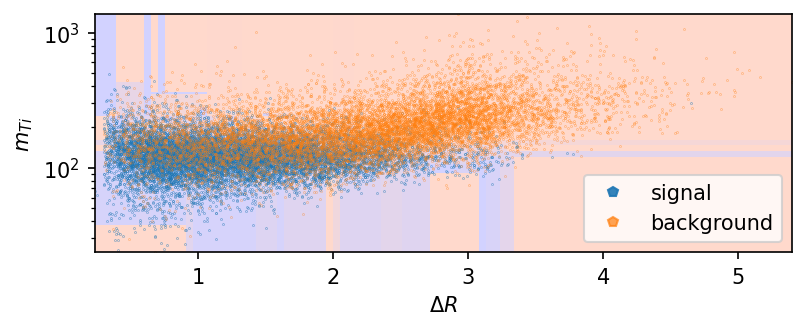

In [ ]:
X = dataset [['drll', 'mTi']].values
y = dataset ['label'].values


from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth = 10, criterion = 'gini', splitter='best')
tree.fit ( X,y )

x_ = np.linspace (X[:,0].min(), X[:,0].max(), 100)
y_ = np.linspace (X[:,1].min(), X[:,1].max(), 100)

xy = np.dstack (np.meshgrid ( x_, y_)).reshape (-1,2)
decision = tree.predict_proba (xy) [:,1]

make_2d_plot ( 'drll', 'mTi', '$\Delta R$', '$m_{Ti}$')
#plt.contour (x_,y_,decision.reshape(100,100), levels = 2, colors = 'k', alpha=0.4)
plt.imshow (decision.reshape(100,100), extent=(x_[0], x_[-1], y_[0], y_[-1]), alpha = 0.25, origin='lower', interpolation='nearest', cmap=cmap)
plt.yscale('log')
plt.show()

A decision tree can be a very powerful tool to make classifications because retaining the ability of understanding the "reasoning" behind the decision, allows to obtain outstanding performance.

To push the performance, one can define a larger number of conditions, a larger number of leaves. But this results quickly in over fitting. 

In the code block below, we try to increase the number of leaves and compute the ROC curve repeatively.

Take the time to play with the options of the Decision Tree and try to understand how the various options modify the behaviour of the Decision Tree.
Explore in particular the following options:
 * *max_depth*: the number of subsequent decision (leaves are $2^\mathrm{max\_depth}$).
 * *splitter*: if `random`, it split the dataset randomly instead of maximising some metric at its `best` value.  
 * *criterion*: can be `gini` to reduce the impurity or `entropy` to best approximate the probability of getting signal for a given input 

[Documentation of the Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

To be more quantitative in the discussion on the performance of the Decision Tree, let's have a look to the ROC curve.

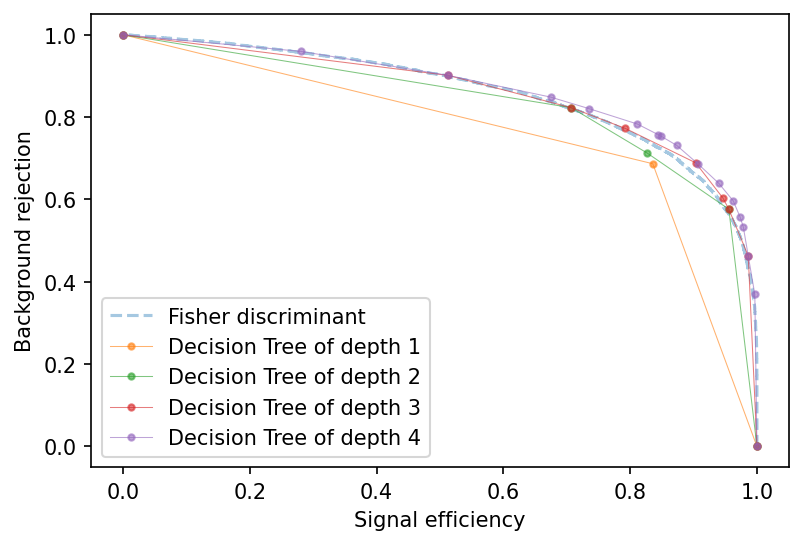

In [ ]:
from sklearn.metrics import roc_curve
draw_fisher_roc (dataset [['drll', 'mTi']].values, dataset['label'].values, alpha = 0.4)

for depth in range(1,5):
  tree = DecisionTreeClassifier(max_depth = depth, splitter = 'best')
  tree.fit ( X,y )
  treed = tree.predict_proba (X) 

  bkgRej, sigRej, _ = roc_curve (dataset['label'].values, treed[:,0])
  plt.plot ( 1.-sigRej, bkgRej, 'o-' , label = 'Decision Tree of depth %d' % depth, linewidth=0.5, alpha=0.6, markersize=3  )

plt.xlabel ("Signal efficiency")
plt.ylabel ("Background rejection")
plt.legend()
plt.show ()

As you have seen, decision trees are great but they result quickly in over-training, by defining tiny leaves that would never generalize to a statisitically independent, but equivalent sample.

However, the boundaries are often very sharp and we could gain something both in generalization and in perfomance using smoother datasets. 
A powerful technique to smooth the boundaries is bagging. 
Instead of training a single decision tree on the whole dataset, we train many decision trees on randomly selected subsamples (named bags) of the original dataset, then we average all of their decisions and take that average as response of the classifier.

Note that this technique of combining several **weak learners** into an averaged **strong learner** is very common and is adopted and applied in a wide range of contexts. The classical example is the election polls: if you ask a single voter what is his or her perception on who will win the elections you might have a rather poor estimate, but if you ask the same question to thousand of voters, your prediction will becomes more reliable. 

Similarly, many web sites started publishing the "super-average" for weather forecast or voters' preferences. These "super-averages" are obtained combining the information obtained by several services studying the data and providing their own predictions. 

In the case of Decision Trees, this technique is sometimes called Random Forest because it is a collection of trees grown with some degree of randomness (in the case of bagging, the randomness comes from the choice of the subsample). 
 

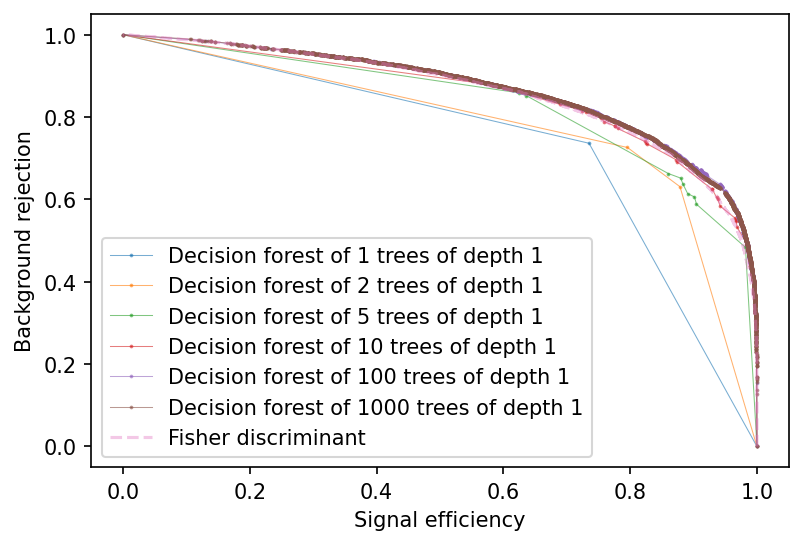

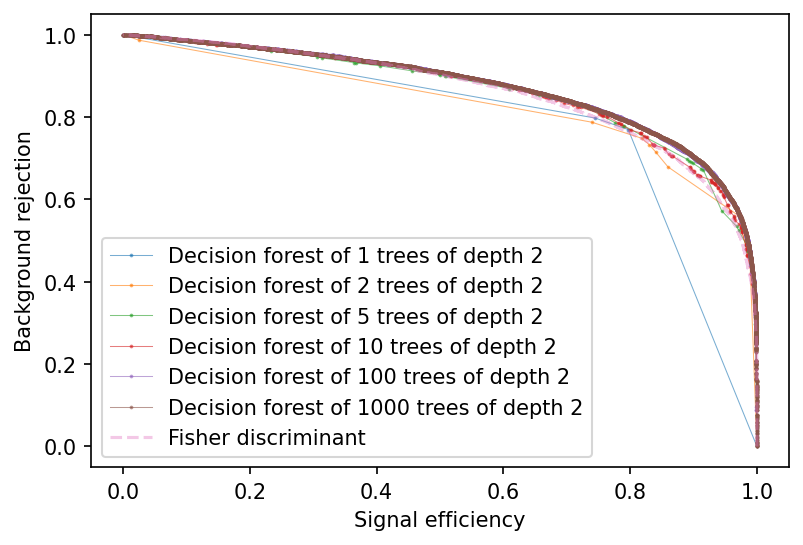

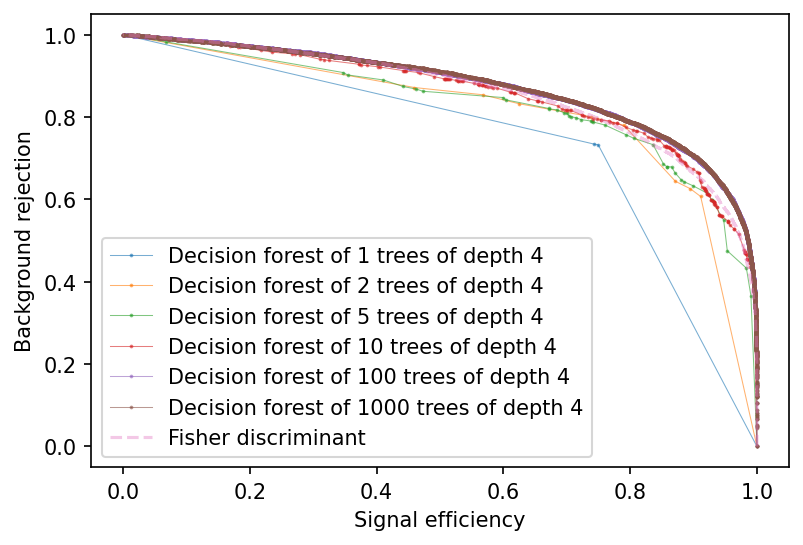

In [ ]:
bag_size = 50
for depth in [1,2,4]:
  for nTrees in [1,2,5,10,100,1000]:
    all_predictions = []
    for decision_tree in range(nTrees):
      resampled_indices = np.random.randint ( 0, len (X), bag_size)
      tree = DecisionTreeClassifier(max_depth = depth, splitter = 'best')
      tree.fit ( X [resampled_indices], y[resampled_indices] )
      all_predictions.append ( tree.predict_proba (X) [:,0] )

    bkgRej, sigRej, _ = roc_curve (dataset['label'].values, np.mean (all_predictions, axis = 0))

    plt.plot ( 1.-sigRej, bkgRej, 'o-', 
              label = 'Decision forest of %d trees of depth %d' % (nTrees, depth), 
              linewidth=0.5, alpha=0.6, markersize=0.8 )

  draw_fisher_roc (dataset [['drll', 'mTi']].values, dataset['label'].values, alpha=0.4)
  plt.xlabel ("Signal efficiency")
  plt.ylabel ("Background rejection")
  plt.legend()
  plt.show ()

Clearly, scikit-learn provides its own interface for bagging, which allows to write more compact code with the standard syntax of scikit learn. 

Note that by default, however, the bags used by scikit-learn have **the same size as the whole sample** but are obtained resampling it with replacements (hence some entry will be missing, some will appear twice). This is another very common trick with deep statistical motivations to reduce the randomness on the prediction of algorithms (or better their variance) and it is named **bootstrap**.

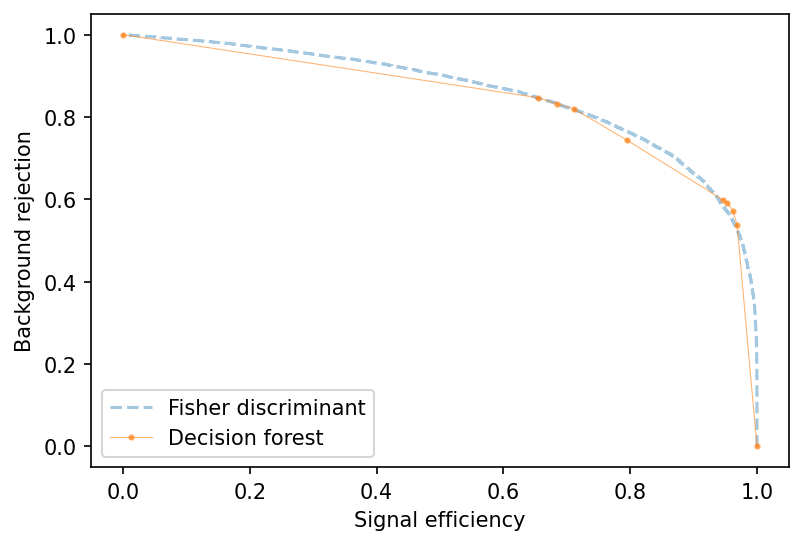

In [ ]:
from sklearn.ensemble import BaggingClassifier

X = dataset [['drll', 'mTi']].values
y = dataset ['label'].values

forest = BaggingClassifier ( DecisionTreeClassifier ( max_depth = 2 ), n_estimators=2 )
forest.fit ( X,y )
prediction = forest.predict_proba (X)[:,0]

draw_fisher_roc (X, y, alpha=0.4)
bkgRej, sigRej, _ = roc_curve (dataset['label'].values, prediction)

plt.plot ( 1.-sigRej, bkgRej, 'o-', label = 'Decision forest', linewidth=0.5, alpha=0.6, markersize=2 )
plt.legend()
plt.xlabel ("Signal efficiency")
plt.ylabel ("Background rejection")

plt.show()

### Exercise 3.1
Try creating a random forest removing the randomness on the choice of the elements included in the bags, but rather randomizing the split of the decision tree. 
Which one performs better? Which one gives origin to a "smoother" prediction? 

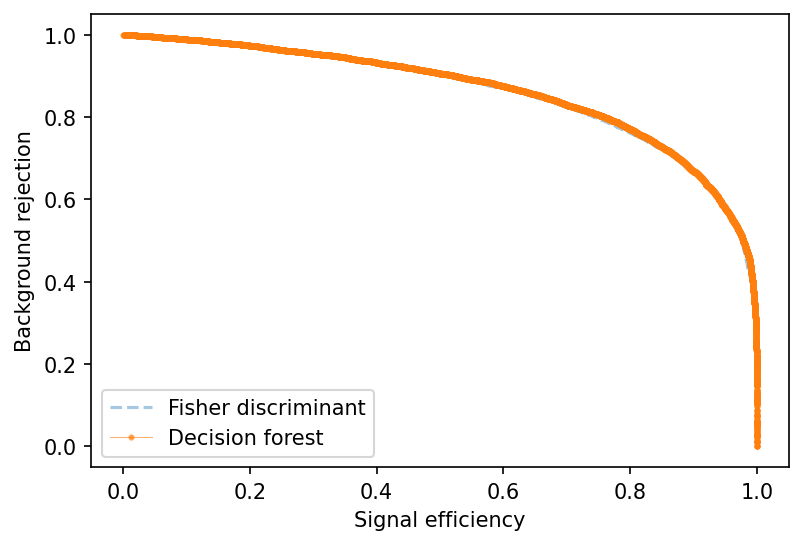

In [ ]:
## Code to be hidden to students 
from sklearn.ensemble import BaggingClassifier

X = dataset [['drll', 'mTi']].values
y = dataset ['label'].values

forest = BaggingClassifier ( DecisionTreeClassifier ( max_depth = 5, splitter = 'random' ), n_estimators=200, bootstrap=False )
forest.fit ( X,y )
prediction = forest.predict_proba (X)[:,0]

draw_fisher_roc (X, y, alpha=0.4)
bkgRej, sigRej, _ = roc_curve (dataset['label'].values, prediction)

plt.plot ( 1.-sigRej, bkgRej, 'o-', label = 'Decision forest', linewidth=0.5, alpha=0.6, markersize=2 )
plt.legend()
plt.xlabel ("Signal efficiency")
plt.ylabel ("Background rejection")

plt.show()

### Boosting the decision tree

We can do something smarter than just randomizing! We can make new trees to compensate the errors introduced by the previous ones. 
There are several techniques to achieve this result, the most common are the **AdaBoost** and the **GradientBoost** that are different implementation of the same principle: train new tree to correct the mistakes of the previous one.

**AdaBoost**ing assign a weight to the data entry which is larger when they are misclassified. In this way, new trees are encouraged to reduce the error on those entries at the expenses of others, already well classified. See the [scikit-learn user's guide](https://scikit-learn.org/stable/modules/ensemble.html#adaboost) for further reference. 

**GradientBoost**ing  is based on the idea that instead of perfoming a classifications, each subsequent decision tree  try to approximate the distance of the loss function (for example the binary cross-entropy) from its minimum.  For further detail, refer to the [the mathematical formulation](https://scikit-learn.org/stable/modules/ensemble.html#mathematical-formulation).

These techniques are, up to date, the most powerful classification techniques. Neural networks can perform as good, or in certain cases slightly better, but are incredibly more difficult to use and necessitate of tuning and data preprocessing to obtain performance that Boosted Decision Tree would achieve at first trial. 

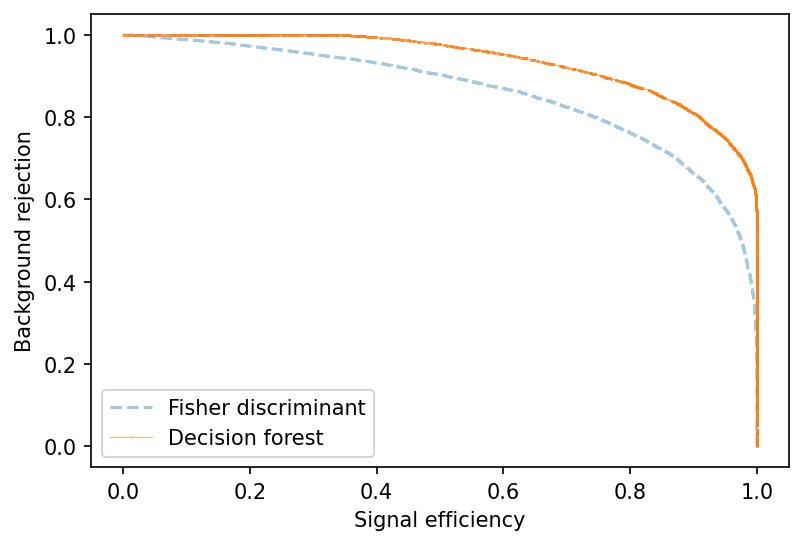

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

X = dataset [['drll', 'mTi']].values
y = dataset ['label'].values

forest = AdaBoostClassifier ( DecisionTreeClassifier ( max_depth = 5 ), n_estimators=100 )
forest.fit ( X,y )
prediction = forest.predict_proba (X)[:,0]

draw_fisher_roc (X, y, alpha=0.4)
bkgRej, sigRej, _ = roc_curve (dataset['label'].values, prediction)

plt.plot ( 1.-sigRej, bkgRej, 'o-', label = 'Decision forest', linewidth=0.5, alpha=0.6, markersize=0.2 )
plt.legend()
plt.xlabel ("Signal efficiency")
plt.ylabel ("Background rejection")

plt.show()

### Exercise 3.2
Helping yourselves with the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn-ensemble-gradientboostingclassifier), try implementing a Gradient Boosted Decision Tree on the same variables.

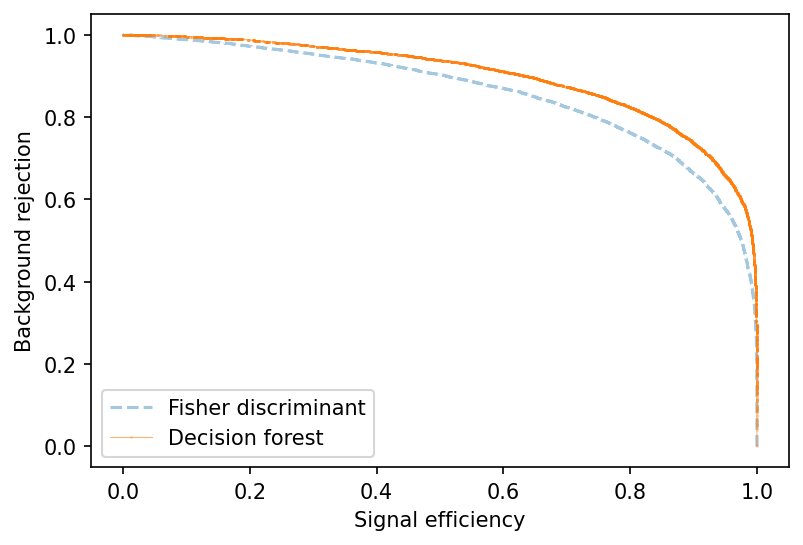

In [ ]:
## Solution to hide.
from sklearn.ensemble import GradientBoostingClassifier

X = dataset [['drll', 'mTi']].values
y = dataset ['label'].values

forest = GradientBoostingClassifier ( n_estimators=100, max_depth = 5 )
forest.fit ( X,y )
prediction = forest.predict_proba (X)[:,0]

draw_fisher_roc (X, y, alpha=0.4)
bkgRej, sigRej, _ = roc_curve (dataset['label'].values, prediction)

plt.plot ( 1.-sigRej, bkgRej, 'o-', label = 'Decision forest', linewidth=0.5, alpha=0.6, markersize=0.2 )
plt.legend()
plt.xlabel ("Signal efficiency")
plt.ylabel ("Background rejection")

plt.show()

But... is all that glitters gold?

Boosted Decision Trees (as most of the advanced machine learning algorithms) are prone to over-training and it is important to ensure that the trained model generalize reasonably well on samples not used during the training.

To check the ability of the formulated prediction to generalize to new instances, we use a sample, statistically inidependent and equivalent to the training sample.

In the following example we compare the predictions obtained with an increasing number of trees composing the forest.

> Try to replace the AdaBoosting with a Gradient Boosting. Do the two techniques behave similarly in terms of robustness against overtraining?

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier

X = dataset [['drll', 'mTi']].values
y = dataset ['label'].values
X_test = dataset_test [['drll', 'mTi']].values
y_test = dataset_test ['label'].values

aucs = []
aucs_test = [] 
trees = list(range ( 1, 20, 1 )) + list(range (20, 100, 10)) + list ( range ( 100, 1000, 100) )
from tqdm import tqdm
for nTrees in tqdm (trees):
  forest = AdaBoostClassifier ( DecisionTreeClassifier ( max_depth = 3 ), n_estimators = nTrees )
  forest.fit ( X, y )
  prediction = forest.predict_proba (X)[:,0]
  prediction_test = forest.predict_proba (X_test)[:,0]

  aucs . append ( roc_auc_score (y, -prediction) )
  aucs_test . append ( roc_auc_score (y_test, -prediction_test) )

100%|██████████| 36/36 [03:06<00:00,  5.19s/it]


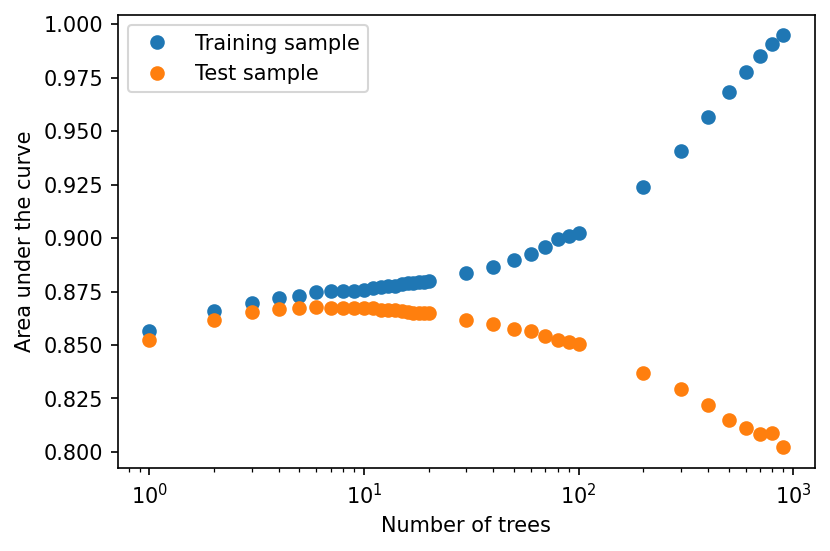

In [ ]:
plt.plot ( trees, aucs, 'o', label = 'Training sample' )
plt.plot ( trees, aucs_test, 'o', label = 'Test sample' )

plt.legend()
plt.xlabel ("Number of trees")
plt.ylabel ("Area under the curve")
plt.xscale ('log')
plt.show()

### Robustness against the curse of dimensionality

The most powerful aspect of Boosted Decision Tree is their incredible robustness against useless variables. This allows to feed the decision tree with a large number of possibly discriminating variables and rely on its ability of focussing on the most important ones.


In [ ]:
## Define the axis for the compuation of the Kolmogorv Distance
axis = np.linspace(0,1,100)

## Import the combinations tool to run over the possible combinations 
from itertools import combinations

## tqdm is a powerful tool to keep track of the progress of some process 
from tqdm import trange

## Initialize a list of results. 
kdists = list()
aucs   = list()

## For each number of variables nVariables in the range (1, all_variables)
for nVariables in trange(1, len(all_variables)):
  ## and for each combination of nVariables variables
  for variables in combinations (all_variables, nVariables):
    ## Load the dataset for the chosen set of variables 
    X = dataset[list(variables)].values

    ## Instanciate and fit the Fisher discriminant  
    lr = GradientBoostingClassifier(n_estimators = 5, max_depth = 3)
    lr.fit (X, dataset['label'].values)

    ## Compute the probability 
    p = lr.predict_proba(X)

    ## Compute the Kolmogorov Distance 
    s_c = np.cumsum ( np.histogram (p[isSignal,1],  bins = axis)[0] ) / nSig
    b_c = np.cumsum ( np.histogram (p[~isSignal,1], bins = axis)[0] ) / nBkg

    kdist = np.max ( np.abs ( s_c - b_c ) )
    auc   = roc_auc_score (y, p[:,1])

    ## Register in the list of the results the set of variables and the 
    ## corresponding metric. 
    kdists.append ((variables, kdist))
    aucs.append ((variables,auc))

100%|██████████| 9/9 [04:28<00:00, 29.82s/it]


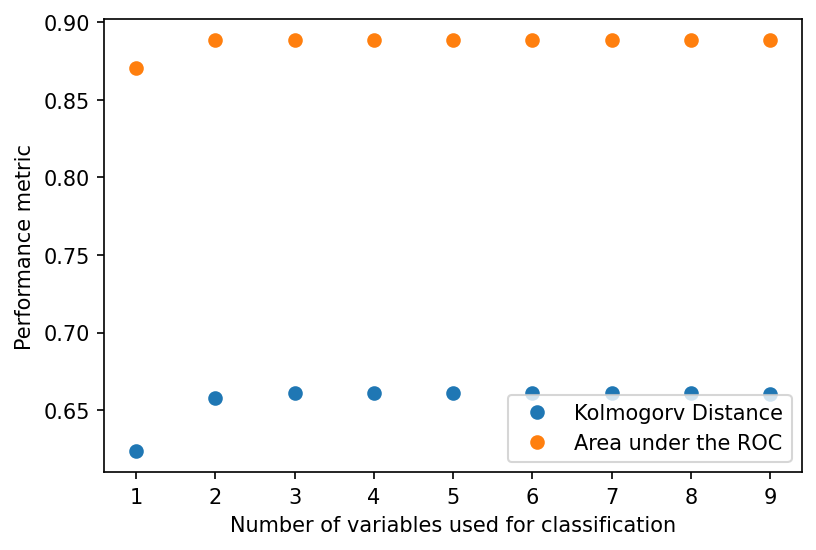

In [ ]:
## Organize the results per number of variables used for training 
kd_per_varlen  = [[] for _ in range(30)]
auc_per_varlen = [[] for _ in range(30)]

for vars, kd in kdists:
  kd_per_varlen [len(vars)].append ( kd )

for vars, auc in aucs:
  auc_per_varlen [len(vars)].append ( auc )

## For each set of variables takes the highest Kolmogorv Distance 
best_kd = [np.max(kds) if len(kds) else 0 for kds in kd_per_varlen]
## and the highest AUC
best_auc = [np.max(aucs) if len(aucs) else 0 for aucs in auc_per_varlen]


## Plot the result as a function of the number of variables 
plt.plot (range(1,10), best_kd[1:10] , 'o', label = 'Kolmogorv Distance')
plt.plot (range(1,10), best_auc[1:10] , 'o', label = 'Area under the ROC')
plt.xlabel ( "Number of variables used for classification")
plt.ylabel ( "Performance metric")
plt.legend()
plt.show()

### Exercise 3.3
Despite they are conceptually similar and often lead to similar performance, AdaBoost and GradBoost have an important difference: value that one reads on the leaves of a trained forest have different meanings. 

Try to compare two BDT trained with AdaBoosting and GradientBoosting on a single variable (for example `mTi`). Don't consider over-training, just use a large number of estimators in both cases. 

The compare the prediction to the ratio of signal events in the dataset in bins of the variable `mTi`.  
Would the boundary between the "signal" and "background" categories be the same? 

Can you conclude something on the statistical meaning of these variables?

Getting back to the definition of the decision trees, can you see a connection between the loss function used and the resulting values on the leaves?

> **Hint**: to compute the ratio of signal events in bins of a variable, construct the histograms of the signal events and of the whole dataset with respect to that variables in bins of that variable and then divide the two histograms. 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


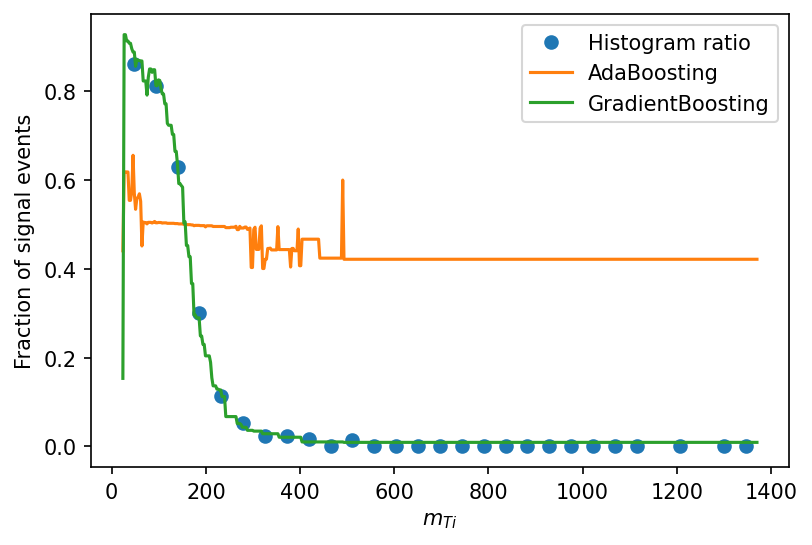

In [ ]:
## This is an interesting exercise that could be discussed during an exam.
adaForest = AdaBoostClassifier ( DecisionTreeClassifier ( max_depth = 2 ), n_estimators = 100 )
adaForest.fit (dataset[['mTi']], dataset[['label']])
gradForest = GradientBoostingClassifier (n_estimators = 500 , max_depth = 1)
gradForest.fit (dataset[['mTi']], dataset[['label']])

bins = np.linspace (dataset['mTi'].min(), dataset['mTi'].max(), 30)
axis = np.linspace (dataset['mTi'].min(), dataset['mTi'].max(), 500)

hSig, _ = np.histogram (signal[['mTi']].values, bins = bins )
hTot, _ = np.histogram (dataset[['mTi']].values, bins = bins )
hFrac = hSig / hTot
plt.plot (0.5*(bins[:-1] + bins[1:]), hFrac, 'o', label = "Histogram ratio")

adaPrediction  = adaForest.predict_proba  ( np.c_ [axis] )[:,1]
gradPrediction = gradForest.predict_proba ( np.c_ [axis] )[:,1]

plt.plot (axis, adaPrediction, label = 'AdaBoosting')
plt.plot (axis, gradPrediction, label = 'GradientBoosting')
plt.legend()

plt.xlabel ("$m_{Ti}$")
plt.ylabel ("Fraction of signal events")

plt.show()